# Goals

  * sentiment analysis on twitter thread interactions.
  * train a model to be able to predict conversation sentiment.

      * based on the first tweet?
      * proactive measures for dealing with customers.


In [96]:
!pip install -q kaggle
from google.colab import files 
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d thoughtvector/customer-support-on-twitter

#in drive https://drive.google.com/drive/u/1/folders/1Sh4w-8e1p2Yl_9QrAvpgRf4nmeY_KW-z

Saving kaggle.json to kaggle (3).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
customer-support-on-twitter.zip: Skipping, found more recently modified local copy (use --force to force download)


In [97]:
!pip install cloudmesh-installer
!pip install cloudmesh-common 

## Import libraries

In [253]:
import time
from cloudmesh.common.StopWatch import StopWatch
from cloudmesh.common.Benchmark import Benchmark
from cloudmesh.common.Shell import Shell

import zipfile 

#dealing with data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
import sklearn
from sklearn.model_selection import train_test_split

#nl libraries
import string 
import nltk #natural language tool kit
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download("vader_lexicon")
nltk.download('punkt')



[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Download and reduce the data working with

In [239]:
StopWatch.start("get_data")

zfile=zipfile.ZipFile('/content/customer-support-on-twitter.zip')
data=pd.read_csv(zfile.open('twcs/twcs.csv')) 

StopWatch.stop("get_data")

print(data.shape)
data.head()

StopWatch.start("manageability")

df=data.drop(['inbound','created_at'],axis=1)
df["text"]=df["text"].astype(str)
df.sample(frac=1)
df=df.head(500) #for easier management i imagine its going to take a long time if we dont cut it down

StopWatch.stop("manageability")


(2811774, 7)


In [240]:
StopWatch.start("removing_companies")

def companies(df):
  idx=[]
  for id in range(len(df["author_id"])):
      vowels=['a','e','i','o', 'u']
      for vowel in vowels:
        if vowel in df["author_id"][id]:
          idx.append(id)
          break 
  return df.drop(idx)

customers=companies(df)

StopWatch.stop("removing_companies")

# Analyze senitment for individual tweets

In [241]:
StopWatch.start("sentiment_score")

sent_analyzer=SentimentIntensityAnalyzer()
#note to self if we dont cut down data then this takes about 13 minutes for refernece
customers["sentiment"]=customers["text"].apply(lambda x: sent_analyzer.polarity_scores(x)["compound"])

StopWatch.stop("sentiment_score")

# Remove companies from dataset and form new dataset

In [245]:
# #show distribution of overall tweets and by customers
cust_average=customers.groupby("author_id")
cust_sent_average=cust_average.sentiment.mean()
cust_sent_average=pd.DataFrame({'author_id':cust_sent_average.index, 'sentiment_average': cust_sent_average.values})

#getting the first tweet for each author
customers = customers[pd.isnull(df.in_response_to_tweet_id)]

#new dataframe with the essentials
customer_first=pd.DataFrame({'author_id':customers['author_id'], 
                             'tweet':customers['text'], 
                             'first_sentiment':customers['sentiment'], 
                             'classification': 'Na'})

#add the overall sentiment average for each author
for author in customer_first['author_id']:
  sentiment=cust_sent_average.loc[cust_sent_average.author_id==author, 'sentiment_average']
  if sentiment.values < 0:
    customer_first.loc[customer_first.author_id==author,'classification'] = "negative"
  else:
        customer_first.loc[customer_first.author_id==author,'classification'] = "positive"

for author in customer_first['author_id']:
  sentiment=customer_first.loc[customer_first.author_id==author, 'first_sentiment']
  if sentiment.values < 0:
    customer_first.loc[customer_first.author_id==author,'first_sentiment'] = "negative"
  else:
        customer_first.loc[customer_first.author_id==author,'first_sentiment'] = "positive"

customer_first.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


,author_id,tweet,first_sentiment,classification
6,115712,@sprintcare is the worst customer service,negative,negative
12,115713,@115714 y’all lie about your “great” connectio...,negative,negative
14,115715,"@115714 whenever I contact customer support, t...",positive,positive
23,115716,actually that's a broken link you sent me and ...,negative,negative
25,115717,"Yo @Ask_Spectrum, your customer service reps a...",positive,positive


# show sentiment distribution

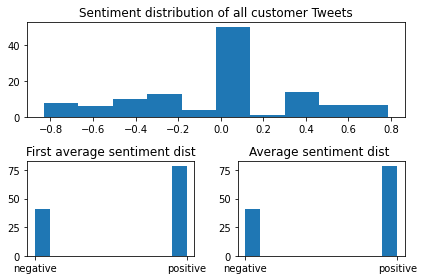

In [246]:
fig=plt.figure()

axs0=plt.subplot(211)
axs0.hist(customers["sentiment"])
axs0.set_title("Sentiment distribution of all customer Tweets")

axs1=plt.subplot(223)
axs1.hist(customer_first["first_sentiment"])
axs1.set_title("First average sentiment dist")

axs2=plt.subplot(224)
axs2.hist(customer_first["classification"])
axs2.set_title("Average sentiment dist ")


plt.tight_layout()
fig.savefig("customer_dist.png")
fig.show()


In [247]:
nltk.download('averaged_perceptron_tagger')

def encode_tweets(df):
  count=0
  encoded=[]
  embedding={}
  for scentence in df.tweet:
    encode=[]
    token=nltk.word_tokenize(scentence.lower())

    token=[ele for word_tuple in nltk.pos_tag(token) for ele in word_tuple ]

    for word in token:
      if word not in embedding:
        embedding[word]=count
        count+=1
      encode.append(embedding[word])
    encoded.append(encode)
  return (encoded)


encoded=encode_tweets(customer_first)

customer_first['tweet']=encoded


customer_first


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,author_id,tweet,first_sentiment,classification
6,115712,"[0, 1, 2, 1, 3, 4, 5, 6, 7, 8, 9, 1, 10, 1]",negative,negative
12,115713,"[0, 11, 12, 13, 14, 15, 16, 17, 18, 6, 19, 17,...",negative,negative
14,115715,"[0, 11, 12, 13, 42, 43, 44, 1, 45, 17, 9, 1, 4...",positive,positive
23,115716,"[69, 11, 70, 6, 71, 4, 72, 6, 73, 25, 74, 1, 7...",negative,negative
25,115717,"[81, 1, 0, 37, 82, 1, 33, 33, 22, 23, 9, 1, 10...",positive,positive
...,...,...,...,...
479,115880,"[435, 13, 986, 1, 801, 21, 154, 6, 225, 25, 98...",positive,positive
483,115881,"[0, 1, 996, 4, 997, 13, 55, 21, 5, 6, 247, 25,...",negative,negative
487,115882,"[0, 25, 695, 1, 102, 43, 193, 36, 176, 11, 235...",negative,negative
494,115883,"[0, 1, 695, 4, 5, 6, 834, 834, 445, 1, 579, 1,...",negative,negative


# Dividing train and test data

In [256]:
#train test split the data should be 80 20 by default 
#fit data into the models 

train_text, test_text, train_sent, test_sent=train_test_split(customer_first['tweet'], 
                                                              customer_first['classification'])
num_classes=3

train_text=train_text.values
test_text=test_text.values

train_text=sequence.pad_sequences(train_text, maxlen=300)
test_text=sequence.pad_sequences(test_text, maxlen=300)

train_sent=train_sent.values
test_sent=test_sent.values






# Cnn model 

In [257]:
#Cnn libraries 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from keras.layers import Conv1D, MaxPooling1D, Flatten, AveragePooling1D, Embedding
from tensorflow.keras.utils import to_categorical, plot_model

# Building the model

In [260]:
word_dict=10000

input_shape=train_text.shape
batch_size=128
kernel_size=3
pool_size=2
filters=64
dropout=0.2
epochs=5



StopWatch.start("cnn_model_building")

cnn_model=Sequential()

cnn_model.add(Conv1D(filters=filters, kernel_size=kernel_size,
                activation='relu', input_shape=input_shape,
                padding='same'))
cnn_model.add(MaxPooling1D(pool_size))

cnn_model.add(Conv1D(filters=filters, kernel_size=kernel_size,
                activation='relu', input_shape=input_shape,
                padding='same'))
cnn_model.add(MaxPooling1D(pool_size))

cnn_model.add(Conv1D(filters=filters, kernel_size=kernel_size,
                activation='relu', input_shape=input_shape,
                padding='same'))
cnn_model.add(MaxPooling1D(pool_size))

cnn_model.add(Conv1D(filters=filters, kernel_size=kernel_size,
                activation='relu', input_shape=input_shape,
                padding='same'))
cnn_model.add(Flatten())
cnn_model.add(Dropout(dropout))
cnn_model.add(Dense(num_labels))
cnn_model.add(Activation('softmax'))
cnn_model.summary()
plot_model(cnn_model, to_file='cnn_model.png', show_shapes=True)

StopWatch.stop("cnn_model_building")

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_31 (Conv1D)           (None, 90, 64)            57664     
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 45, 64)            0         
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 45, 64)            12352     
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 22, 64)            0         
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 22, 64)            12352     
_________________________________________________________________
max_pooling1d_23 (MaxPooling (None, 11, 64)            0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 11, 64)          

# Compile 

In [262]:
StopWatch.start("cnn_compile")
cnn_model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', metrics=['accuracy'])
StopWatch.stop("cnn_compile")

# Model Fit

In [263]:
StopWatch.start("cnn_train")
cnn_model.fit(train_text, train_sent, batch_size=batch_size,epochs=epochs)
StopWatch.stop("cnn_train")

Epoch 1/5


ValueError: ignored

# Evaluate

In [ ]:
StopWatch.start("cnn_evaluate")
cnn_loss, cnn_accuracy=cnn_model.evaluate(test_text, test_sent, batch_size = batch_size)
print("CNN Accuracy: %.1f%%" %(100.0*cnn_accuracy))
StopWatch.stop("cnn_evaluate")